In [126]:
# !pip -q install pandas openpyxl matplotlib transformers "numpy<2" torch==2.3.0 nltk squarify spacy vaderSentiment textblob seaborn

In [127]:
# runtime ~45s

import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
import seaborn as sns
import matplotlib.pyplot as plt

# Define file paths
filepath = r"combined_df.csv"

# Read the csv files into DataFrames
combined_df = pd.read_csv(filepath) 

# Filter recent reviews
combined_df['Month of Response Date'] = pd.to_datetime(combined_df['Month of Response Date'])
combined_df = combined_df[combined_df['Month of Response Date'] >= '2024-04-01'].reset_index(drop=True)

# combined_df.head(3)
len(combined_df)

8140

In [128]:
df = combined_df

# Count the frequency of each token count
token_count_summary = df['token_count'].value_counts().sort_index()

# Convert to DataFrame for better readability
token_count_summary_df = token_count_summary.reset_index()
token_count_summary_df.columns = ['Token Count', 'Row Count']
token_count_summary_df = token_count_summary_df[token_count_summary_df['Token Count'] >= 512]


token_count_summary_df.sort_values(by='Token Count', ascending=False).reset_index(drop=True)

,Token Count,Row Count
0,1092,1
1,890,1
2,864,1
3,779,1
4,669,1
5,523,1
6,520,1


In [129]:
combined_df['Combined Text'][1]

'Great price and arrived even earlier than stated.'

In [130]:
# Aspect-Based Sentiment Analysis (ABSA) ZeroShot
# No Fine-Tuning: Uses pre-trained models without specific training on target data
# Generalization: Leverages knowledge from diverse training to analyze unseen text
# Data Efficiency: Useful when labeled aspect data is limited or unavailable

from transformers import pipeline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# load the pipeline and models

# pipeline for Sentiment Analysis (SA)
# sa1: distilbert/distilbert-base-uncased-finetuned-sst-2-english -> # https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english?library=transformers
# sa2: siebert/sentiment-roberta-large-english -> # https://huggingface.co/siebert/sentiment-roberta-large-english?library=transformers
# sa3: avichr/heBERT_sentiment_analysis -> # https://huggingface.co/avichr/heBERT_sentiment_analysis?library=transformers

sa1 = pipeline("text-classification", model="distilbert/distilbert-base-uncased-finetuned-sst-2-english", truncation=True)
sa2 = pipeline("text-classification", model="siebert/sentiment-roberta-large-english", truncation=True)
sa3 = pipeline("text-classification", model="avichr/heBERT_sentiment_analysis", truncation=True)

# pipeline for Extractive Question-Answering (QA)
# qa1: deepset/roberta-base-squad2 -> # https://huggingface.co/deepset/roberta-base-squad2?library=transformers
# qa2: distilbert/distilbert-base-cased-distilled-squad -> # https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad?library=transformers
# qa3: google-bert/bert-large-uncased-whole-word-masking-finetuned-squad -> # https://huggingface.co/google-bert/bert-large-uncased-whole-word-masking-finetuned-squad?library=transformers

qa1 = pipeline("question-answering", model="deepset/roberta-base-squad2")       
qa2 = pipeline("question-answering", model="distilbert/distilbert-base-cased-distilled-squad")    
qa3 = pipeline("question-answering", model="google-bert/bert-large-uncased-whole-word-masking-finetuned-squad")

# pipeline for Zero-Shot Classification w NLI (NLI), better to identify keywords for candidate_labels
# nli1: facebook/bart-large-mnli -> # https://huggingface.co/facebook/bart-large-mnli?library=transformers
# nli2: MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli -> # https://huggingface.co/MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli?library=transformers
# nli3: cross-encoder/nli-roberta-base -> # https://huggingface.co/cross-encoder/nli-roberta-base?library=transformers

nli1 = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
nli2 = pipeline("zero-shot-classification", model="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli")
nli3 = pipeline("zero-shot-classification", model="cross-encoder/nli-roberta-base")

# Specify candidate labels for nli
candidate_labels = ["positive comment", "negative comment", "neutral comment"]
                                                     
# text = "This movie was absolutely amazing!"
text = combined_df['Combined Text'][1]

print(f"Text: {text}\n\n"
      f"sa1: {sa1(text, truncation=True, max_length=512)}\n"
      f"sa2: {sa2(text, truncation=True, max_length=512)}\n"
      f"sa3: {sa3(text, truncation=True, max_length=512)}\n\n"
      f"qa1: {qa1(question='What is this comment about?', context=text, truncation=True, max_length=512)}\n"
      f"qa2: {qa2(question='What is this comment about?', context=text, truncation=True, max_length=512)}\n"
      f"qa3: {qa3(question='What is this comment about?', context=text, truncation=True, max_length=512)}\n\n"
      f"nli1: {nli1(text, candidate_labels=candidate_labels, truncation=True, max_length=512)}\n"
      f"nli1: {nli2(text, candidate_labels=candidate_labels, truncation=True, max_length=512)}\n"
      f"nli1: {nli3(text, candidate_labels=candidate_labels, truncation=True, max_length=512)}\n"
      )


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Text: Great price and arrived even earlier than stated.

sa1: [{'label': 'POSITIVE', 'score': 0.982696533203125}]
sa2: [{'label': 'POSITIVE', 'score': 0.9988464117050171}]
sa3: [{'label': 'neutral', 'score': 0.9910248517990112}]

qa1: {'score': 0.20314031839370728, 'start': 0, 'end': 11, 'answer': 'Great price'}
qa2: {'score': 0.9155565500259399, 'start': 0, 'end': 11, 'answer': 'Great price'}
qa3: {'score': 0.27474722266197205, 'start': 0, 'end': 36, 'answer': 'Great price and arrived even earlier'}

nli1: {'sequence': 'Great price and arrived even earlier than stated.', 'labels': ['positive comment', 'neutral comment', 'negative comment'], 'scores': [0.9862350821495056, 0.008527233265340328, 0.005237707868218422]}
nli1: {'sequence': 'Great price and arrived even earlier than stated.', 'labels': ['positive comment', 'neutral comment', 'negative comment'], 'scores': [0.9843230843544006, 0.014562034979462624, 0.0011148907942697406]}
nli1: {'sequence': 'Great price and arrived even earli

In [131]:
# Zero-shot Classification sa and nli of 'Combined Text'
# runtime 
# 10 rows : 6s
# 100 rows : 78s
# 1,000 rows : 780s / 13mins (est)
# 10,000 rows : 7800s / 2hrs (est)
# 100,000 rows : 78000s / 10hrs (est)


sa_combined_df = combined_df[combined_df['token_count'] <= 200].copy()

def get_sentiment_labels(text):
    if isinstance(text, str):  # Check if the input is a valid string
        # Get results from each pipeline
        result_sa1 = sa1(text)[0]
        result_sa2 = sa2(text)[0]
        result_sa3 = sa3(text)[0]
        
        # Return the labels with the highest scores
        label_sa1 = result_sa1['label']
        label_sa2 = result_sa2['label']
        label_sa3 = result_sa3['label']
        
        return pd.Series([label_sa1, label_sa2, label_sa3])
    else:
        # Return 'Unknown' for non-string inputs
        return pd.Series(['Unknown', 'Unknown', 'Unknown'])
    
# Define a function to extract NLI labels for all three models
def get_nli_labels(text):
    if isinstance(text, str):  # Check if the input is a valid string
        # Perform zero-shot classification with candidate labels for each model
        # Specify candidate labels for nli
        candidate_labels = ["positive comment", "negative comment", "neutral comment"]
        result_nli1 = nli1(text, candidate_labels=candidate_labels)
        result_nli2 = nli2(text, candidate_labels=candidate_labels)
        result_nli3 = nli3(text, candidate_labels=candidate_labels)
        
        # Extract the label with the highest probability from each result
        label_nli1 = result_nli1['labels'][0]  # First label is the highest probability
        label_nli2 = result_nli2['labels'][0]
        label_nli3 = result_nli3['labels'][0]
        
        return pd.Series([label_nli1, label_nli2, label_nli3])
    else:
        # Return 'Unknown' for non-string inputs
        return pd.Series(['Unknown', 'Unknown', 'Unknown'])

# Apply the function to each row in the 'Combined Text' column and create new columns
sa_combined_df[['sa1_label', 'sa2_label', 'sa3_label']] = sa_combined_df['Combined Text'].apply(get_sentiment_labels)
sa_combined_df[['nli1_label', 'nli2_label', 'nli3_label']] = sa_combined_df['Combined Text'].apply(get_nli_labels)

sa_combined_df.head(3)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


,Survey ID,Product Name,Print Customer Region,LTR,Source Type,Survey language,Review Source,Star Rating,Product Family,Supplies Family,...,token_count,Response Date,Month of Response Date,predicted_level1,sa1_label,sa2_label,sa3_label,nli1_label,nli2_label,nli3_label
0,110020182,HP 63 Black Original Ink Cartridge,US,10,Web Reviews,English,Walmart,5.0,Supplies - Ink,Dolmen Refresh,...,7,2024-04-01 01:00:00,2024-04-01,"Logistic Handling, General satisfied",POSITIVE,POSITIVE,negative,positive comment,positive comment,positive comment
1,123460320,HP 65XL Black Original Ink Cartridge,US,10,Web Reviews,English,Walmart,5.0,Supplies - Ink,Dolmen Refresh,...,8,2024-04-01 01:00:00,2024-04-01,Logistic Handling,POSITIVE,POSITIVE,neutral,positive comment,positive comment,positive comment
2,132417974,HP 65XL Black Original Ink Cartridge,US,10,Web Reviews,English,Walmart,5.0,Supplies - Ink,Dolmen Refresh,...,40,2024-04-06 01:00:00,2024-04-01,Others,POSITIVE,POSITIVE,negative,negative comment,positive comment,neutral comment


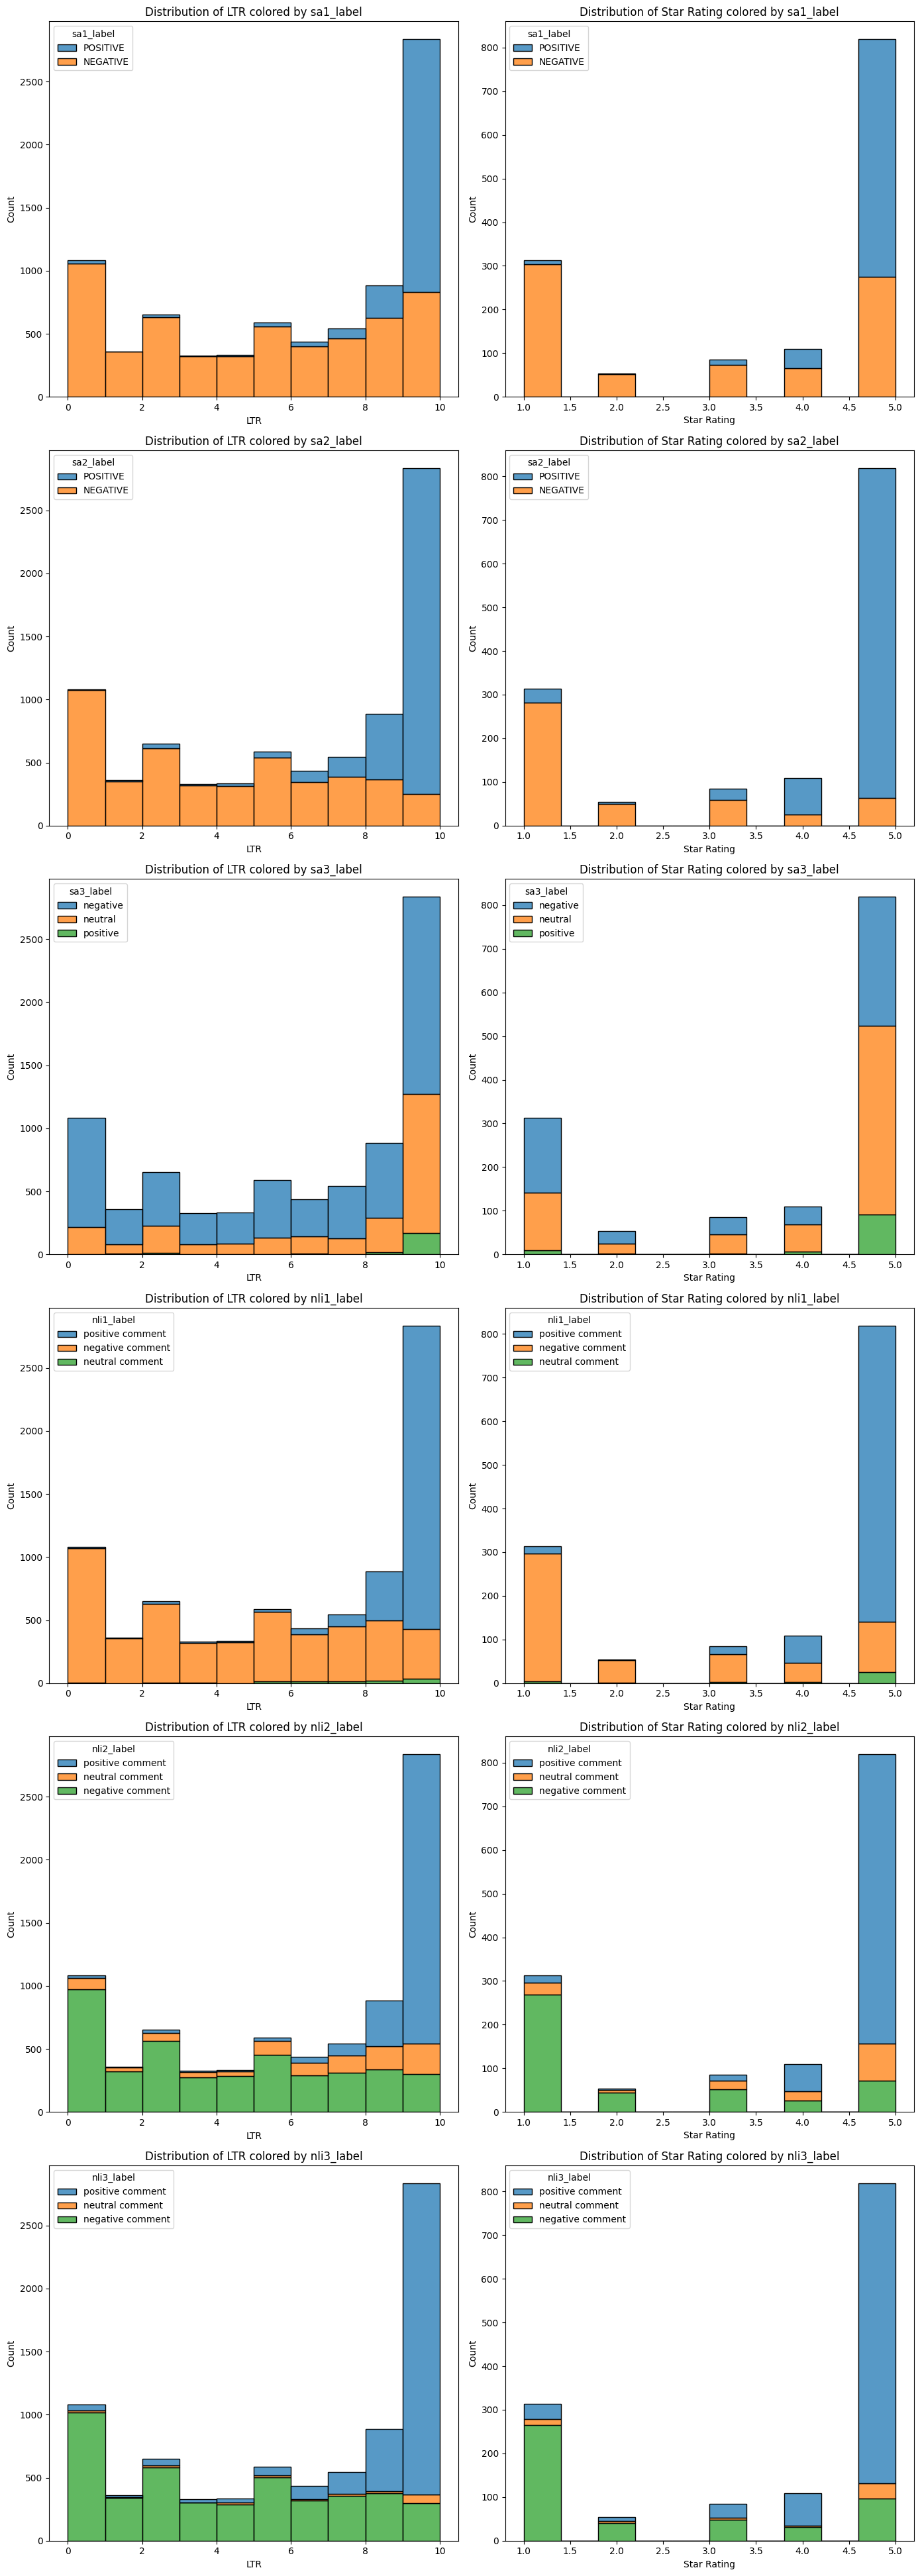

In [133]:
# Distribution Plot

# Define the columns to plot
columns_to_plot = ['LTR', 'Star Rating']
color_cols = ['sa1_label', 'sa2_label', 'sa3_label', 'nli1_label', 'nli2_label', 'nli3_label']  # Add as many color columns as needed

# Ensure that LTR and Star Rating columns are numeric for proper sorting
sa_combined_df['LTR'] = pd.to_numeric(sa_combined_df['LTR'], errors='coerce')
sa_combined_df['Star Rating'] = pd.to_numeric(sa_combined_df['Star Rating'], errors='coerce')

# Create a figure for subplots
plt.figure(figsize=(14, 39))

# Loop through each color column and create subplots
for j, color_col in enumerate(color_cols):
    for i, col in enumerate(columns_to_plot, 1):
        plt.subplot(len(color_cols), 2, j * 2 + i)  # Create grid of subplots
        sns.histplot(data=sa_combined_df, x=col, hue=color_col, kde=False, multiple="stack", bins=10)
        plt.title(f'Distribution of {col} colored by {color_col}')
        plt.xlabel(col)
        plt.ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()

In [134]:
# sa_combined_df

sa_combined_df.to_csv('sa_combined_df.csv', index=False)

In [13]:
# Multi-turn Zero-shot ABSA on 
# 50 rows -> ~1min

reviews = combined_df['Combined Text'].head(10)

nli = nli1

# Define categories
cats = ["printer", "ink", "service", "delivery", "general"]

# Initialize result list and sentence count
results = []
scount = 0

# Process each review
for r in reviews:
    scount += 1
    s = r  # Since each review is already one sentence, no need for tokenization
    labels = []

    # Find applicable categories
    for c in cats:
        yes = f"It's a comment on {c}"
        no = f"It's not a comment on {c}"
        res = nli(s, candidate_labels=[yes, no])
        label = res['labels'][0]
        if res['scores'][0] >= 0.9 and "not" not in label:
            labels.append(c)

    # If no specific category is detected, assign "general"
    if not labels:
        labels.append('general')

    # Determine the polarity for each detected category
    for l in labels:
        if l == "general":
            pos = "This is a positive comment in general"
            neg = "This is a negative comment in general"
            neu = "This is a neutral comment in general"
        else:
            pos = f"This is a positive comment on {l}"
            neg = f"This is a negative comment on {l}"
            neu = f"This is a neutral comment on {l}"

        # Determine sentiment using zero-shot classification
        res2 = nli(s, candidate_labels=[pos, neg, neu])
        polarity = res2['labels'][0]
        results.append({
            "sentence": s,
            "cat": l,
            "polarity": polarity[10:13],  # Extract polarity label
            "polarity_score": res2['scores'][0]
        })

print(f"Processed {scount} sentences.")

Processed 10 sentences.


In [20]:
df_results

,sentence,cat,polarity,polarity_score
0,Reasonable priced with a high capacity of prints.,printer,pos,0.945281
1,"Quick delivery, easy to order!",service,pos,0.985326
2,"Quick delivery, easy to order!",delivery,pos,0.990614
3,I bought HP ink for my printer and it is the o...,printer,pos,0.965404
4,I bought HP ink for my printer and it is the o...,ink,pos,0.971685
5,Best price for good ink cartridge. Easy to ins...,printer,pos,0.950388
6,Best price for good ink cartridge. Easy to ins...,ink,pos,0.982713
7,always buy brand have had such bad luck with a...,ink,neg,0.984772
8,always buy brand have had such bad luck with a...,service,neg,0.964529
9,Have used HP printers and ink for over 40 year...,printer,pos,0.983712


In [18]:
df_results = pd.DataFrame(results)
summary = pd.crosstab(df_results['cat'], df_results['polarity'])

df_summary = pd.DataFrame(summary)
df_summary["category"] = df_summary.index

df_summary["pos"] = df_summary["pos"] if "pos" in df_summary.columns else 0
df_summary["neg"] = df_summary["neg"] if "neg" in df_summary.columns else 0
df_summary["neu"] = df_summary["neu"] if "neu" in df_summary.columns else 0

# Calculate the total
df_summary["total"] = df_summary["pos"]+df_summary["neg"]+df_summary["neu"]
# represent overall sentiment for the categary based on num of pos/neg
df_summary["sentiment"] = np.round((df_summary["pos"]-df_summary["neg"])/(df_summary["neg"]+df_summary["pos"]),2)

df_results
df_summary

polarity,neg,pos,category,neu,total,sentiment
cat,,,,,,
delivery,0,1,delivery,0,1,1.00
general,0,1,general,0,1,1.00
ink,3,4,ink,0,7,0.14
printer,1,5,printer,0,6,0.67
service,3,2,service,0,5,-0.20


Text(0.5, 1.0, 'Sentiment Heat Map of Combined Review Aspects')

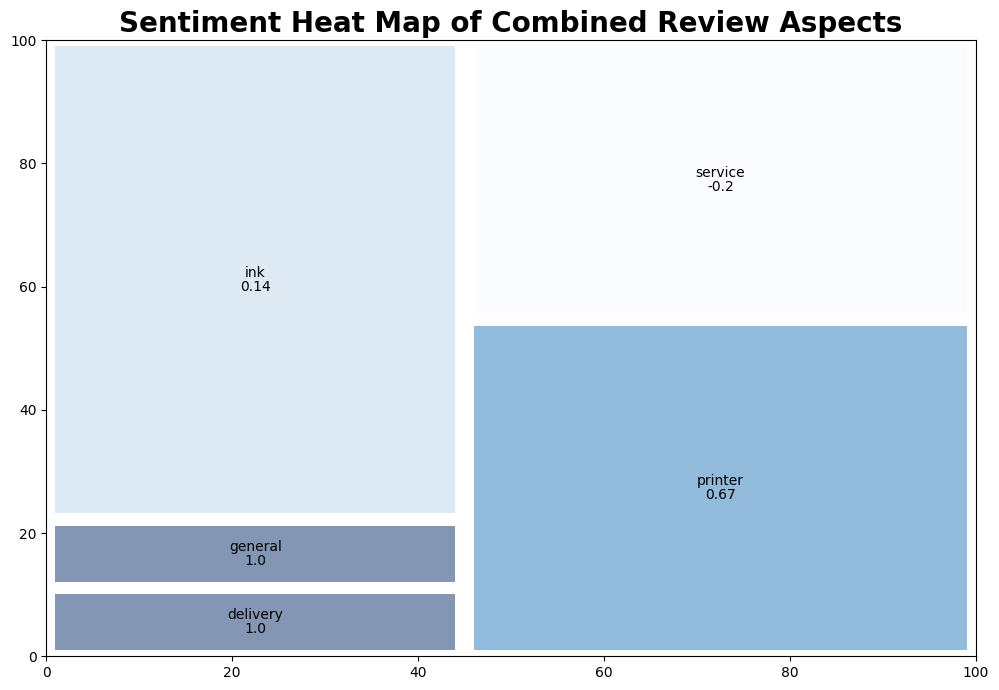

In [19]:
import squarify
import matplotlib
import matplotlib.pyplot as plt

norm = matplotlib.colors.Normalize(vmin=min(df_summary.sentiment), vmax=max(df_summary.sentiment))
colors = [matplotlib.cm.Blues(norm(value)) for value in df_summary.sentiment]

fig = plt.gcf()
fig.set_size_inches(12, 8)

#Use squarify to plot our data, label it and add colours. We add an alpha layer to ensure black labels show through
# Also used color intensity to reflect the sentiment value.
squarify.plot(label=df_summary.category,sizes=df_summary.total, value = df_summary.sentiment,color = colors, alpha=.5, pad =True)
plt.title("Sentiment Heat Map of Combined Review Aspects",fontsize=20,fontweight="bold")